# Databases
#### #1
- Name: Gas Sensor Array Drift Dataset Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 13910
- Area: Computer
- Attribute Characteristics: Real
- Number of Attributes: 128
- Date Donated: 2012-04-25
- Associated Tasks: Classification
- Missing Values? No
- Number of Web Hits: 147103
- Link: https://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset

#### #2
- Name: Insurance Company Benchmark (COIL 2000) Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 9000
- Area: Social
- Attribute Characteristics: Categorical, Integer
- Number of Attributes: 86
- Date Donated: 2000-07-03
- Associated Tasks: Regression, Description
- Missing Values? No
- Number of Web Hits: 161966
- Link: http://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29

#### #3
- Name: Breast Cancer Wisconsin (Diagnostic) Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 569
- Area: Life
- Attribute Characteristics: Real
- Number of Attributes: 32
- Date Donated: 1995-11-01
- Associated Tasks: Classification
- Missing Values? No
- Number of Web Hits: 1392853
- Link: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

#### #4
- Name: Online News Popularity Data Set
- Data Set Characteristics: Multivariate
- Number of Instances: 39797
- Area: Business
- Attribute Characteristics: Integer, Real
- Number of Attributes: 61
- Date Donated: 2015-05-31
- Associated Tasks: Classification, Regression
- Missing Values? No
- Number of Web Hits: 312185
- Link: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity

#### #5
- Name: Epileptic Seizure Recognition Data Set
- Data Set Characteristics: Multivariate, Time-Series
- Number of Instances: 11500
- Area: Life
- Attribute Characteristics: Integer, Real
- Number of Attributes: 179
- Date Donated: 2017-05-24
- Associated Tasks: Classification, Clustering
- Missing Values? No
- Number of Web Hits: 122456
- Link: https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

In [4]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

from deslib.static.oracle import Oracle
from marianaasouza.sgh import SGH
from reference.rlo.rlo import random_linear_oracle

## Database pre-processing

### Gas Sensor Array Drift

In [5]:
def parse_cell(cell_value):
    value = str(cell_value).split(":")
    return value[1] if len(value) > 1 else value[0]

gas_n_batch = 10
gas_base_batch_name = "batch{}.dat"
gas_batch_filenames = [gas_base_batch_name.format(i) for i in range(1, gas_n_batch+1)]

gas_dataframes = []
for filename in gas_batch_filenames:
    df = pd.read_csv("./databases/gas-sensor-array-drift/" + filename, header=None, sep=" ")
    gas_dataframes.append(df)

gas_data = pd.concat(gas_dataframes, axis=0, ignore_index=True)
gas_n_row, gas_n_column = gas_data.shape
gas_columns = ['y'] + ["X{}".format(i) for i in range(0, gas_n_column-1)]
gas_data.columns = gas_columns
gas_data = gas_data.applymap(lambda x: parse_cell(x))
gas_data = gas_data.apply(pd.to_numeric, errors='ignore')

gas_data["y"] = gas_data["y"].apply(lambda x: x - 1)

gas_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127
0,0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,...,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529
1,0,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,...,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225
2,0,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,...,-2.384784,-2.867291,5914.6685,5.396827,1.403973,2.476956,3.039841,-1.334558,-1.993659,-2.348370
3,0,42825.9883,3.451192,12.113940,16.266853,39.910056,-7.849409,-9.689894,-11.921704,38379.0664,...,-2.607199,-3.058086,6147.4744,5.501071,1.981933,3.569823,4.049197,-1.432205,-2.146158,-2.488957
4,0,58151.1757,4.194839,11.455096,15.715298,17.654915,-11.083364,-13.580692,-16.407848,51975.5899,...,-3.594763,-4.181920,8158.6449,7.174334,1.993808,3.829303,4.402448,-1.930107,-2.931265,-4.088756


### Insurance Company Benchmark

In [6]:
insurance_train_file = "ticdata2000.txt"
insurance_test_file = "ticeval2000.txt"
insurance_test_labels_file = "tictgts2000.txt"

insurance_train_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_train_file, header=None, sep="\t")
insurance_test_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_test_file, header=None, sep="\t")
insurance_test_labels_data = pd.read_csv("./databases/insurance-company-benchmark/" + insurance_test_labels_file, header=None, sep="\t")

insurance_test_data = pd.concat([insurance_test_data, insurance_test_labels_data], axis=1, ignore_index=True)
insurance_data = pd.concat([insurance_train_data, insurance_test_data], axis=0, ignore_index=True)

insurance_n_row, insurance_n_column = insurance_data.shape
insurance_columns = ["X{}".format(i) for i in range(0, insurance_n_column-1)] + ["y"]
insurance_data.columns = insurance_columns

insurance_data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X76,X77,X78,X79,X80,X81,X82,X83,X84,y
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [7]:
dict(collections.Counter(list(insurance_data["y"])))

{0: 9236, 1: 586}

### Breast Cancer Wisconsin (Diagnostic)

In [8]:
wdbc_data = pd.read_csv("./databases/wdbc/wdbc.data", header=None)
del wdbc_data[0]
wdbc_n_row, wdbc_n_column = wdbc_data.shape
wdbc_columns = ["y"] + ["X{}".format(i) for i in range(0, wdbc_n_column-1)]
wdbc_data.columns = wdbc_columns
wdbc_data["y"] = wdbc_data["y"].apply(lambda x: 0 if x == "M" else 1)
wdbc_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Online News Popularity

In [9]:
popularity_data = pd.read_csv("./databases/online-news-popularity/OnlineNewsPopularity.csv")
popularity_data = popularity_data.drop(columns=["url"])
popularity_data.columns = list(map(lambda x: x.strip(), popularity_data.columns))
popularity_data["y"] = popularity_data["shares"].apply(lambda x: 0 if x < 1400 else 1)
popularity_data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,y
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,1
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0


### Epileptic Seizure Recognition

In [10]:
epileptic_data = pd.read_csv("./databases/epileptic-seizure-recognition/data.csv")
epileptic_n_row, epileptic_n_column = epileptic_data.shape
epileptic_columns = ["X{}".format(i) for i in range(0, epileptic_n_column-1)] + ["y"]
epileptic_data.columns = epileptic_columns
epileptic_data = epileptic_data.drop(columns=["X0"])

epileptic_data["y"] = epileptic_data["y"].apply(lambda x: x - 1)

epileptic_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,3
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,0
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,4
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,4
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,4


### Databases characteristics and class distribution

Bases de dados utilizadas neste trabalho, ordenadas pela quantidade de instâncias:

Database | # Instances | # Attributes | # Classes
------ | ------ | ------ | ------
Breast Cancer | **569** | **32** | **2**
Insurance Company Benchmark | **9822** | **86** | **2**
Epileptic Seizure Recognition | **11500** | **179** | **5**
Gas Sensor Array Drift | **13910** | **128** | **6**
Online News Popularity | **39797** | **61** | **2**

In [11]:
def plot_class_distribution(class_data, database_name):
    %matplotlib inline
    plt.figure(figsize=(8,6))
    
    instances = dict(collections.Counter(list(class_data)))
    instances = collections.OrderedDict(sorted(instances.items()))
    instances = [i[1] for i in list(instances.items())]
    
    plt.bar(list(class_data.unique()), instances)
    plt.title("{}: Class distribution".format(database_name))
    plt.ylabel("# of instances")
    plt.xlabel("Classes")
    plt.xticks(list(class_data.unique()))

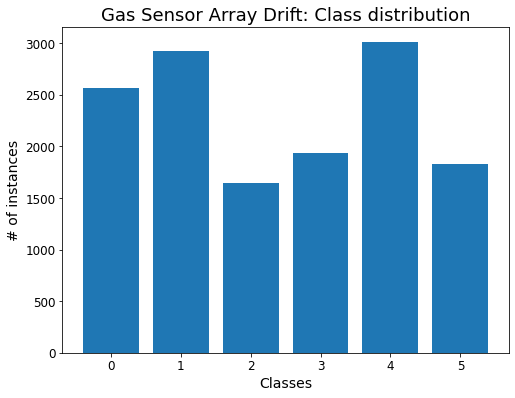

In [271]:
plot_class_distribution(gas_data["y"], "Gas Sensor Array Drift")

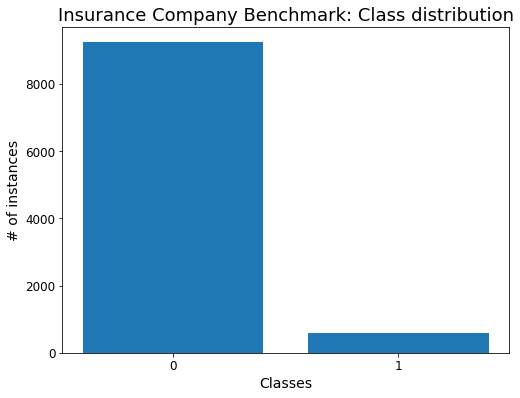

In [272]:
plot_class_distribution(insurance_data["y"], "Insurance Company Benchmark")

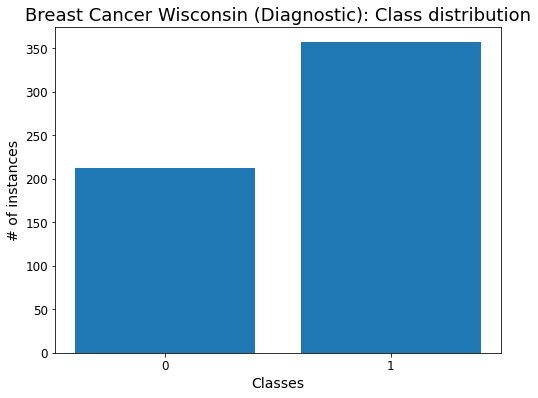

In [273]:
plot_class_distribution(wdbc_data["y"], "Breast Cancer Wisconsin (Diagnostic)")

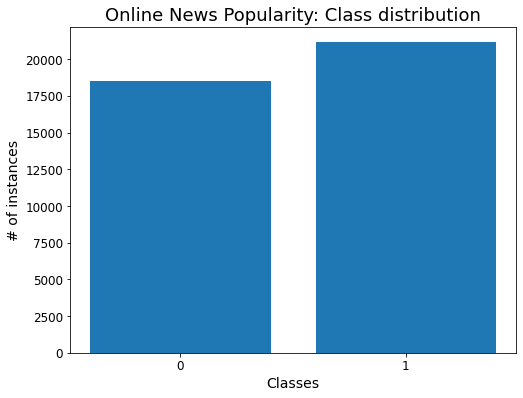

In [274]:
plot_class_distribution(popularity_data["y"], "Online News Popularity")

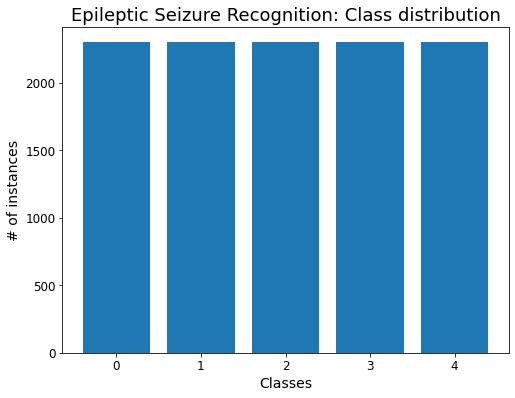

In [275]:
plot_class_distribution(epileptic_data["y"], "Epileptic Seizure Recognition")

## Results Analysis

In [23]:
import json
import statistics
import itertools

ensemble_methods = ["Bagging", "AdaBoost", "Random Subspace", "RLO"]

In [26]:
plt.style.use('./presentation.mplstyle')

In [174]:
def get_mean_stdev(results):
    oracle_scores = {}
    for ensemble_method in ensemble_methods:
        oracle_scores[ensemble_method] = {}
        for pool_config in list(results[ensemble_method].items()):
            scores = list(map(lambda x: x["oracle_score"], pool_config[1]))
            oracle_scores[ensemble_method][pool_config[0]] = (statistics.mean(scores), statistics.stdev(scores))
            
    return oracle_scores

In [175]:
def flatten(array):
    return list(itertools.chain(*list(array)))

In [176]:
def parse_ensemble_pool_scores(results):
    oracle_scores = {}
    for ensemble_method in ensemble_methods:
        oracle_scores[ensemble_method] = {}
        for pool_config in list(results[ensemble_method].items()):
            oracle_scores[ensemble_method][pool_config[0]] = list(map(lambda x: x["oracle_score"], pool_config[1]))
    return oracle_scores

In [177]:
def parse_data_to_line_plot(database):
    parsed = {}
    for ensemble in database.keys():
        parsed[ensemble] = list(map(lambda x: x[0], database[ensemble].values()))
        
    return parsed
        
def line_plot(data_array, title, ylabel="Oracle score", xlabel="Pool size", xticks=[i for i in range(10, 110, 10)], yticks_step=0.0005):
    d0 = flatten(data_array.values())
    cmap=["red", "green", "blue", "black"]

    plt.figure(figsize=(15, 8))
    for x, (label, data) in enumerate(data_array.items()):
        plt.plot(xticks, data, c=cmap[x], label=label)

    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(data_array.keys()))    
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(xticks)
    plt.yticks(list(np.arange(min(d0), max(d0), yticks_step)))
    plt.grid()
    plt.show()

In [188]:
def box_plot_all_ensemble(database, title):
    oracle_scores = {}
    for method in database.keys():
        oracle_scores[method] = flatten(database[method].values())
    pools_sizes = [i for i in range(10, 110, 10) for x in range(0,5)]

    oracle_scores_df = pd.DataFrame.from_dict(oracle_scores)

    oracle_scores_df["Pool"] = pools_sizes

    gas_box = oracle_scores_df.boxplot(by=["Pool"], figsize=(15,12), fontsize="large")
    fig = gas_box[0][0].get_figure()
    fig.suptitle(title)
    return gas_box, oracle_scores_df

In [179]:
gas_results_json = json.load(open("./results/gas.json"))
insurance_results_json = json.load(open("./results/insurance.json"))
wdbc_results_json = json.load(open("./results/wdbc.json"))
popularity_results_json = json.load(open("./results/popularity.json"))
epileptic_results_json = json.load(open("./results/epileptic.json"))

In [180]:
gas_oracle_results = get_mean_stdev(gas_results_json)
insurance_oracle_results = get_mean_stdev(insurance_results_json)
wdbc_oracle_results = get_mean_stdev(wdbc_results_json)
popularity_oracle_results = get_mean_stdev(popularity_results_json)
epileptic_oracle_results = get_mean_stdev(epileptic_results_json)

Gas Sensor Array Drift

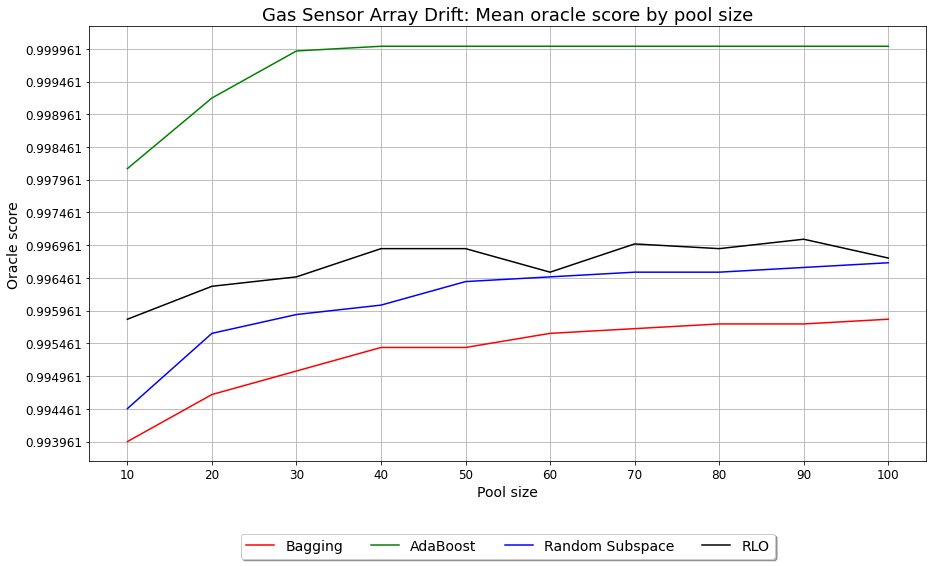

In [21]:
line_plot(parse_data_to_line_plot(gas_oracle_results), "Gas Sensor Array Drift: Mean oracle score by pool size")

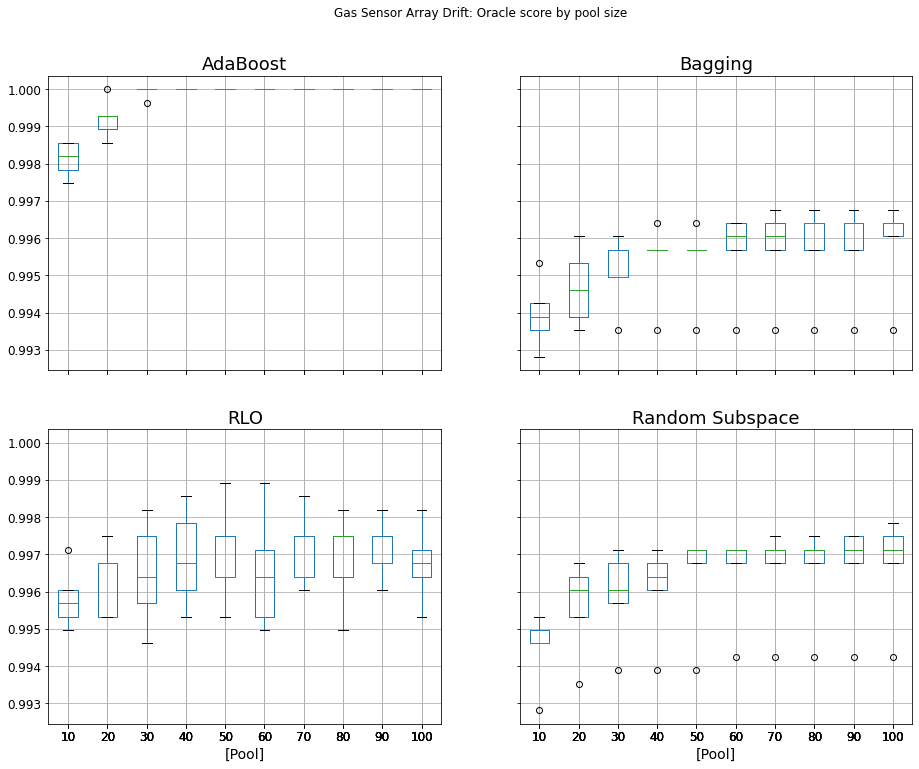

In [190]:
gas_box, gas_oracle_scores_df = box_plot_all_ensemble(parse_ensemble_pool_scores(gas_results_json), "Gas Sensor Array Drift: Oracle score by pool size")

Insurance Company Benchmark

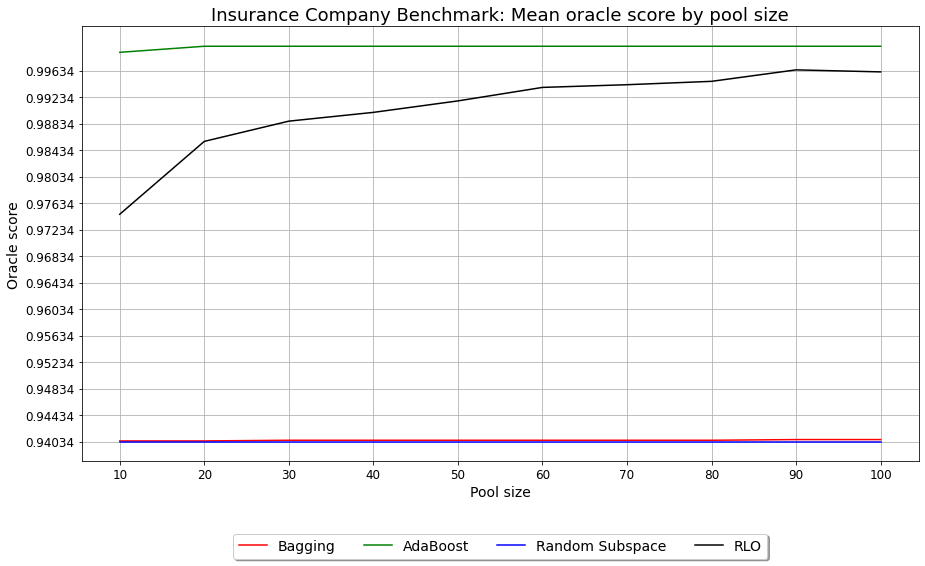

In [23]:
line_plot(parse_data_to_line_plot(insurance_oracle_results), "Insurance Company Benchmark: Mean oracle score by pool size", yticks_step=0.004)

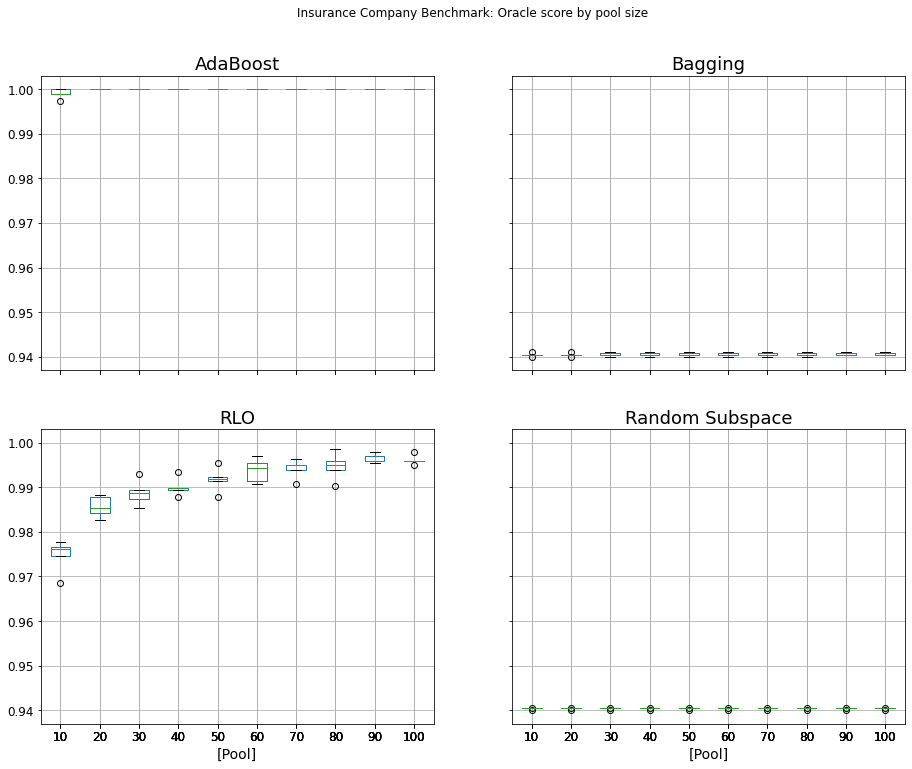

In [24]:
insurance_box, insurance_oracle_scores_df = box_plot_all_ensemble(parse_ensemble_pool_scores(insurance_results_json), "Insurance Company Benchmark: Oracle score by pool size")

Breast Cancer Wisconsin (Diagnostic)

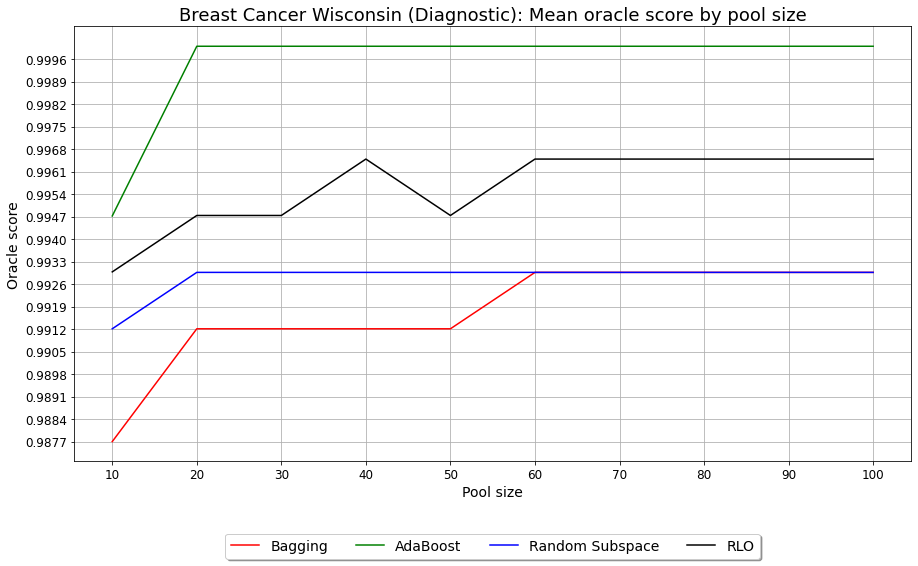

In [25]:
line_plot(parse_data_to_line_plot(wdbc_oracle_results), "Breast Cancer Wisconsin (Diagnostic): Mean oracle score by pool size", yticks_step=0.0007)

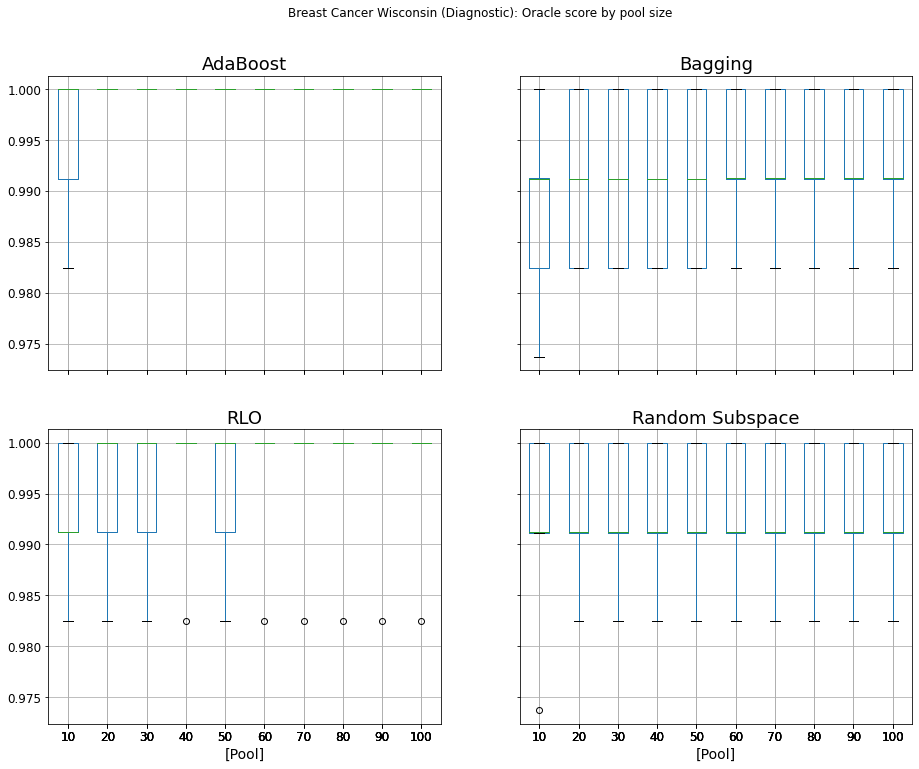

In [26]:
wdbc_box, wdbc_oracle_scores_df = box_plot_all_ensemble(parse_ensemble_pool_scores(wdbc_results_json), "Breast Cancer Wisconsin (Diagnostic): Oracle score by pool size")

Online News Popularity

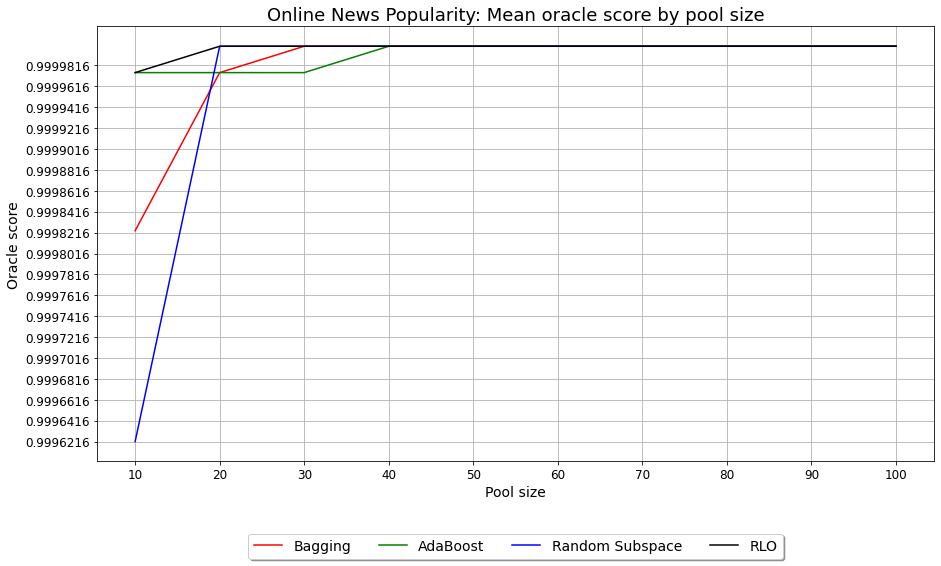

In [27]:
line_plot(parse_data_to_line_plot(popularity_oracle_results), "Online News Popularity: Mean oracle score by pool size", yticks_step=0.00002)

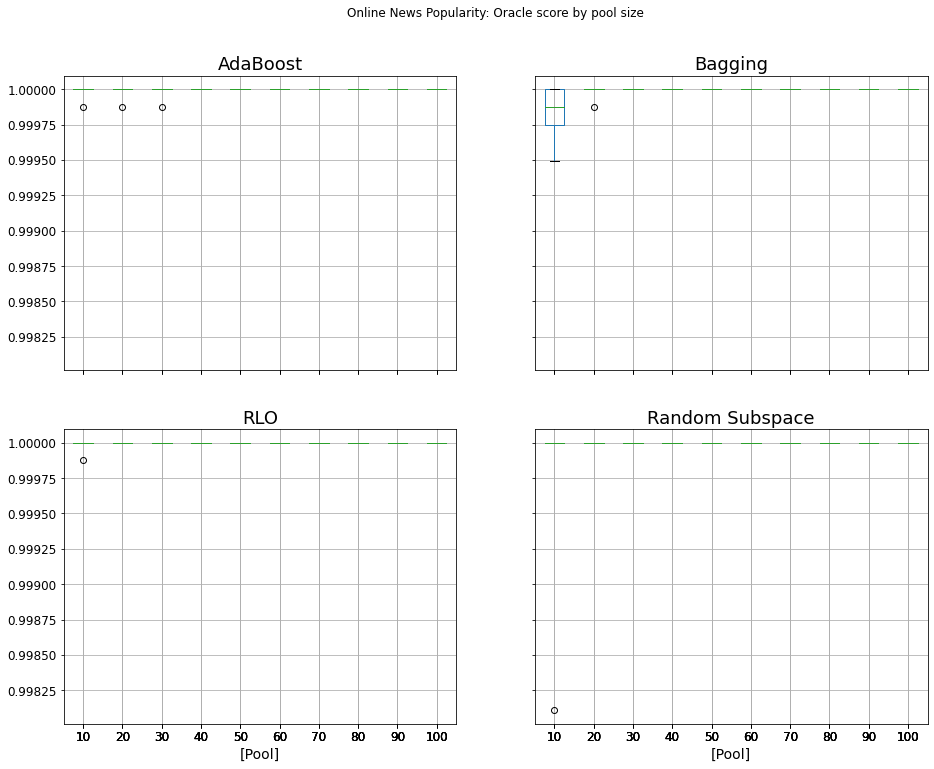

In [28]:
popularity_box, popularity_oracle_scores_df = box_plot_all_ensemble(parse_ensemble_pool_scores(popularity_results_json), "Online News Popularity: Oracle score by pool size")

Epileptic Seizure Recognition

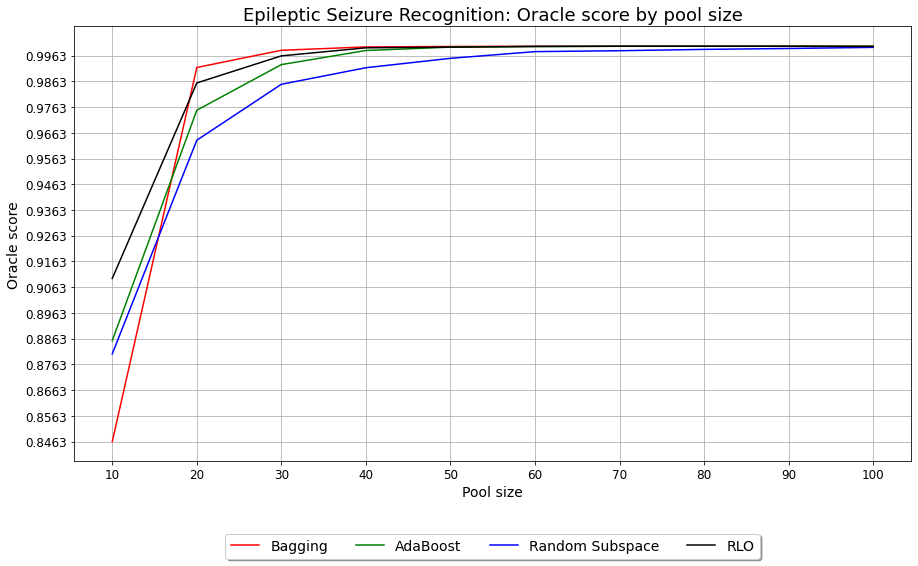

In [29]:
line_plot(parse_data_to_line_plot(epileptic_oracle_results), "Epileptic Seizure Recognition: Oracle score by pool size", yticks_step=0.01)

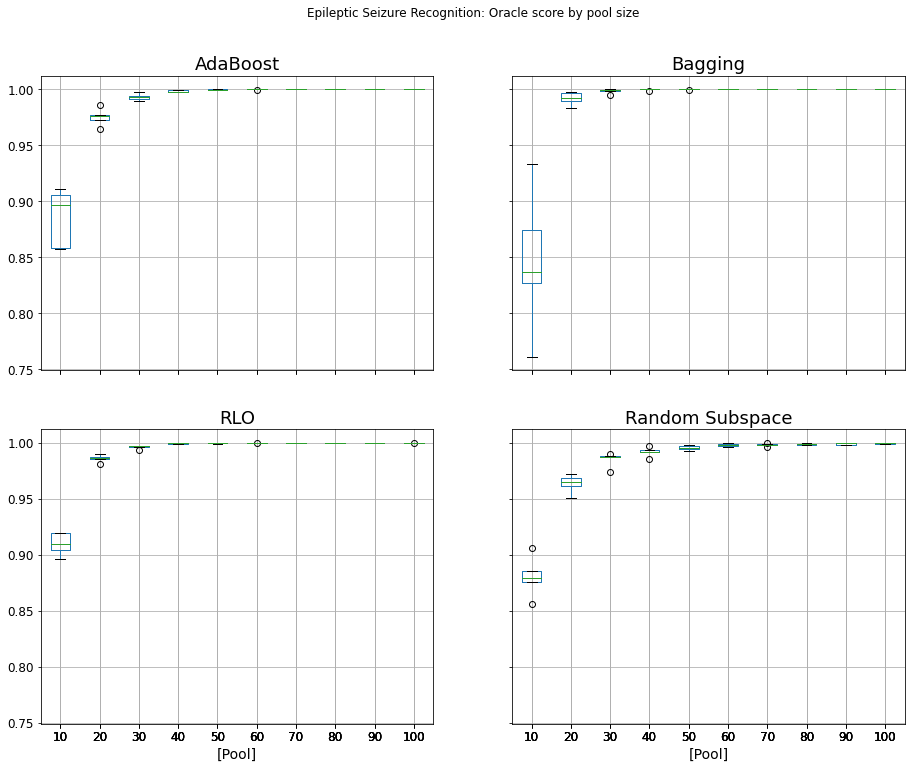

In [30]:
epileptic_box, epileptic_oracle_scores_df = box_plot_all_ensemble(parse_ensemble_pool_scores(epileptic_results_json), "Epileptic Seizure Recognition: Oracle score by pool size")

### SGH

- Use o SGH para gerar o pool de classificadores no conjunto de treinamento;
- Calcule o Oracle do pool no conjunto de teste;
- Verifique quantas instâncias por classe foram incorretamente classificadas;
- Verifique quantos hiperplanos por classe foram gerados.

In [12]:
import warnings
import pickle
import matplotlib.patches as mpatches
from collections import Counter

In [13]:
def load_sgh_results(database_name):
    with open('./results/{}_sgh2.json'.format(database_name), 'rb') as f:
        return pickle.load(f)

gas_sgh_results_json = load_sgh_results("gas")
insurance_sgh_results_json = load_sgh_results("insurance")
wdbc_sgh_results_json = load_sgh_results("wdbc")
popularity_sgh_results_json = load_sgh_results("popularity")
epileptic_sgh_results_json = load_sgh_results("epileptic")

In [14]:
def box_plot_all_ensemble_sgh(database, title):
    oracle_scores_df = pd.DataFrame.from_dict(database)

    gas_box = oracle_scores_df.boxplot(figsize=(12, 8), fontsize="large")
    gas_box.set_title(title)
    return gas_box, oracle_scores_df

In [15]:
def parse_ensemble_pool_scores_sgh(results):
    oracle_scores = {}
    for database in results.keys():
        oracle_scores[database] = list(map(lambda x: x["oracle_score"], results[database]))
    return oracle_scores

In [16]:
def get_results_overall(results):
    dataframe = {}
    for name, data in results.items():
        scores = list(map(lambda x: x["oracle_score"], data))
        hyperplans = list(map(lambda x: len(x["hyperplans_per_classes"]), data))
        dataframe[name] = [statistics.mean(scores), statistics.stdev(scores), statistics.mean(hyperplans), statistics.stdev(hyperplans)]

    return pd.DataFrame.from_dict(dataframe, orient='index', columns=["Mean score", "Stdev score", "Mean hyperplans", "Stdev hyperplans"])

In [17]:
def count_hyperplans_per_class(results):
    hyperplans = {}
    for result in results:
        for cls1, cls2 in result['hyperplans_per_classes']:
            if cls1 not in hyperplans:
                hyperplans[cls1] = 0
            if cls2 not in hyperplans:
                hyperplans[cls2] = 0
            hyperplans[cls1] += 1
            hyperplans[cls2] += 1
    for cls in hyperplans:
        hyperplans[cls] /= len(results)
    return hyperplans

In [18]:
def count_wrong_instance_prediction_per_class(results, classes = []):
    mismatches_class = {clazz: 0 for clazz in classes}
    for result in results:
        mismatches = list(filter(lambda x: x[0] != x[1], zip(result["predicted"], result["expected"])))
        for mismatch in mismatches:
            if mismatch[0] not in mismatches_class:
                mismatches_class[mismatch[0]] = 0
            if mismatch[1] not in mismatches_class:
                mismatches_class[mismatch[1]] = 0
            mismatches_class[mismatch[0]] += 1
            mismatches_class[mismatch[1]] += 1

    for cls in mismatches_class:
        mismatches_class[cls] /= len(gas_sgh_results_json)

    return mismatches_class

In [19]:
def get_number_of_instances_hyperplans(df, json, title, class_label="y"):
    instances = dict(Counter(list(df["y"])))
    hyperplans = count_hyperplans_per_class(json)

    classes = list(instances.keys())
    classes.sort()
    dataframe = {}
    for clazz in classes:
        dataframe[clazz] = [instances[clazz], hyperplans[clazz]]

    df = pd.DataFrame.from_dict(dataframe, orient='index', columns=["# of instances", "Mean hyperplans"])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    df.plot(kind='bar', secondary_y=["Mean hyperplans"], legend=False, ax=ax, rot=0)
    
    ax.set_ylabel("# of instances")
    ax.right_ax.set_ylabel("Mean hyperplans")
    ax.set_xlabel("Classes")
    
    L = [mpatches.Patch(color=c, label=col) 
     for col,c in zip(df.columns, plt.rcParams['axes.prop_cycle'].by_key()['color'])]

    plt.legend(handles=L, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    plt.title(title)

    plt.show()

In [20]:
def get_number_of_wrong_prediction(df, json, title, class_label="y"):
    instances = dict(Counter(list(df["y"])))
    classes = list(instances.keys())
    classes.sort()
    
    wrong_prediction = count_wrong_instance_prediction_per_class(json, classes)
    
    dataframe = {}
    for clazz in classes:
        dataframe[clazz] = [instances[clazz], wrong_prediction[clazz]]

    df = pd.DataFrame.from_dict(dataframe, orient='index', columns=["# of instances", "Mean wrong prediction"])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    df.plot(kind='bar', secondary_y=["Mean wrong prediction"], legend=False, ax=ax, rot=0)
    
    ax.set_ylabel("# of instances")
    ax.right_ax.set_ylabel("Mean wrong prediction")
    ax.set_xlabel("Classes")
    
    L = [mpatches.Patch(color=c, label=col) 
     for col,c in zip(df.columns, plt.rcParams['axes.prop_cycle'].by_key()['color'])]

    plt.legend(handles=L, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    plt.title(title)

    plt.show()

In [21]:
sgh_all_dbs = dict(zip(["Gas Sensor Array Drift", "Insurance Company Benchmark", "Breast Cancer Wisconsin (Diagnostic)", "Online News Popularity", "Epileptic Seizure Recognition"], [gas_sgh_results_json, insurance_sgh_results_json, wdbc_sgh_results_json, popularity_sgh_results_json, epileptic_sgh_results_json]))

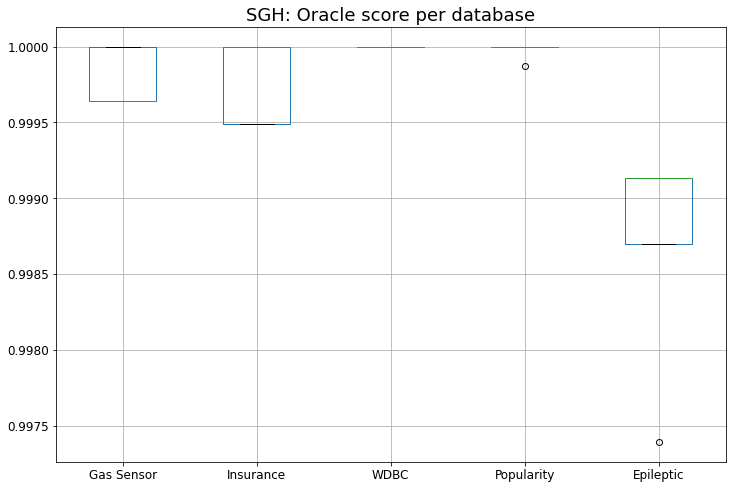

In [197]:
gas_box, oracle_scores_df = box_plot_all_ensemble_sgh(parse_ensemble_pool_scores_sgh(sgh_all_dbs), "SGH: Oracle score per database")

In [24]:
sgh_results_df = get_results_overall(sgh_all_dbs)
sgh_results_df.sort_values(by=['Mean hyperplans'])

,Mean score,Stdev score,Mean hyperplans,Stdev hyperplans
Breast Cancer Wisconsin (Diagnostic),1.000000,0.000000,2.8,0.447214
Insurance Company Benchmark,0.999796,0.000279,3.8,0.447214
Online News Popularity,0.999975,0.000056,4.6,0.547723
Gas Sensor Array Drift,0.999784,0.000197,10.6,1.140175
Epileptic Seizure Recognition,0.998696,0.000753,13.6,1.673320


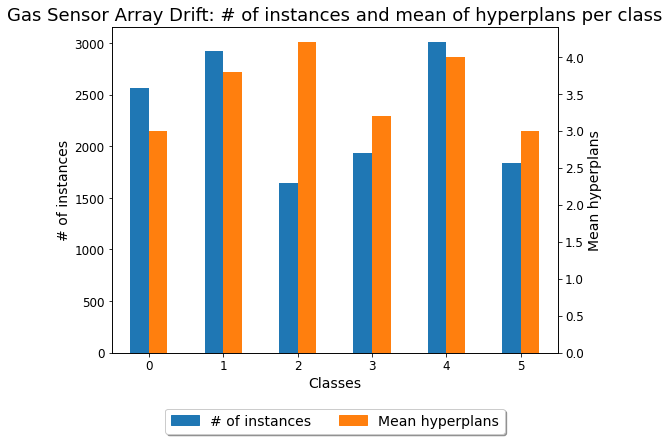

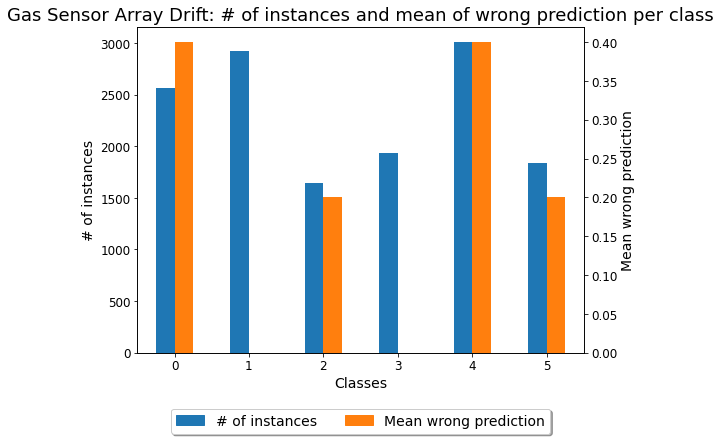

In [30]:
get_number_of_instances_hyperplans(gas_data, gas_sgh_results_json, "Gas Sensor Array Drift: # of instances and mean of hyperplans per class"), 
get_number_of_wrong_prediction(gas_data, gas_sgh_results_json, "Gas Sensor Array Drift: # of instances and mean of wrong prediction per class")

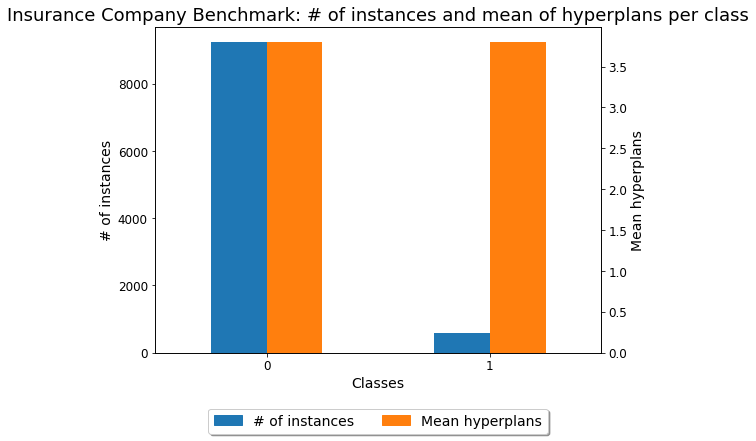

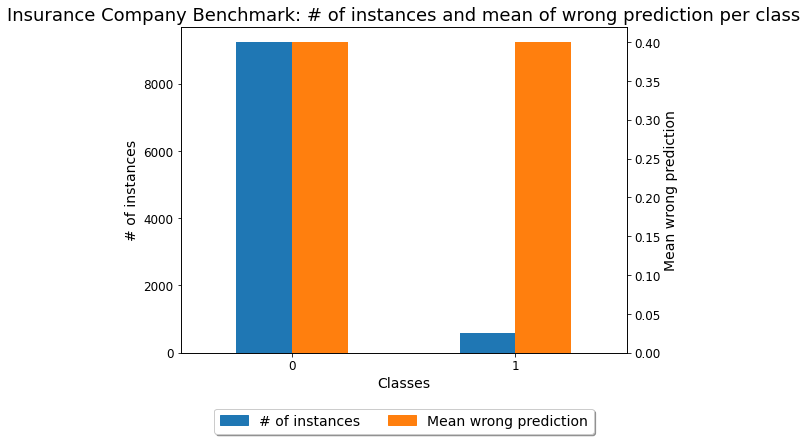

In [28]:
get_number_of_instances_hyperplans(insurance_data, insurance_sgh_results_json, "Insurance Company Benchmark: # of instances and mean of hyperplans per class"), 
get_number_of_wrong_prediction(insurance_data, insurance_sgh_results_json, "Insurance Company Benchmark: # of instances and mean of wrong prediction per class")

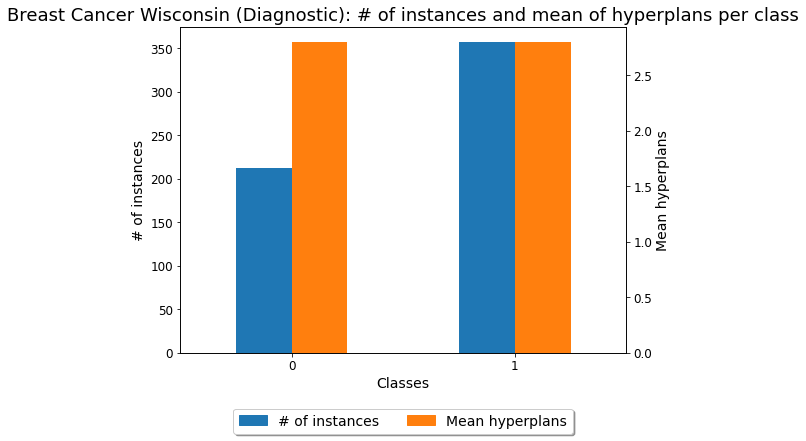

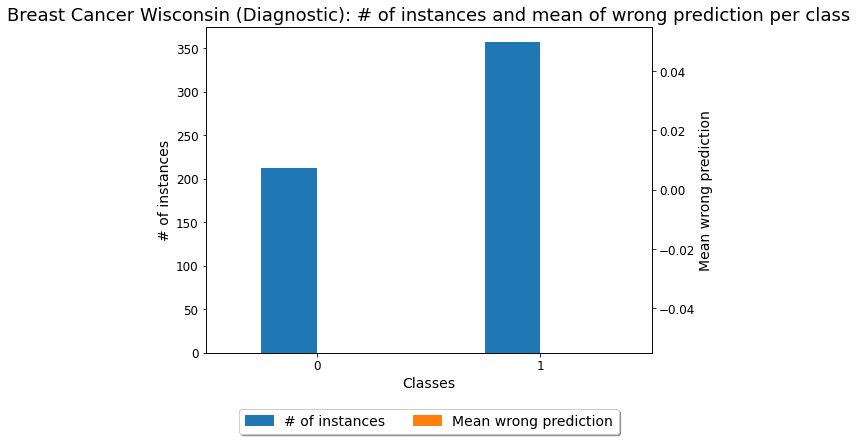

In [27]:
get_number_of_instances_hyperplans(wdbc_data, wdbc_sgh_results_json, "Breast Cancer Wisconsin (Diagnostic): # of instances and mean of hyperplans per class"), 
get_number_of_wrong_prediction(wdbc_data, wdbc_sgh_results_json, "Breast Cancer Wisconsin (Diagnostic): # of instances and mean of wrong prediction per class")

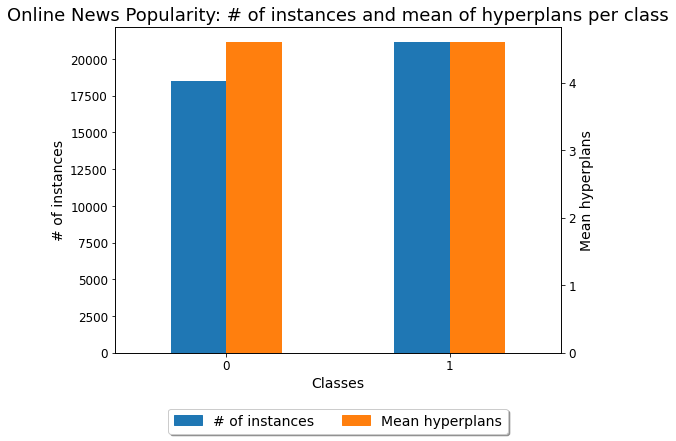

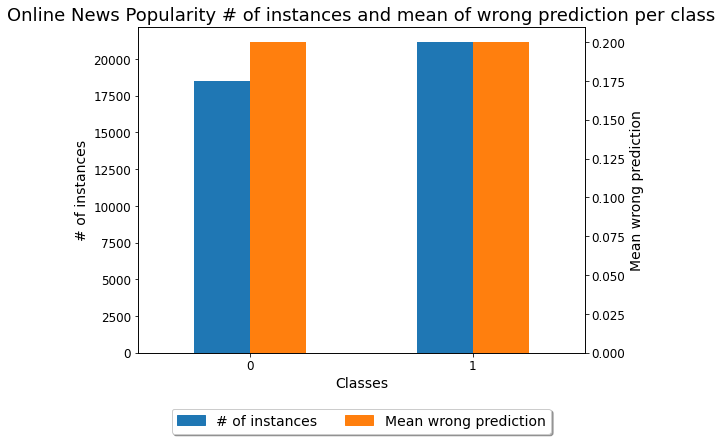

In [31]:
get_number_of_instances_hyperplans(popularity_data, popularity_sgh_results_json, "Online News Popularity: # of instances and mean of hyperplans per class"), 
get_number_of_wrong_prediction(popularity_data, popularity_sgh_results_json, "Online News Popularity # of instances and mean of wrong prediction per class")

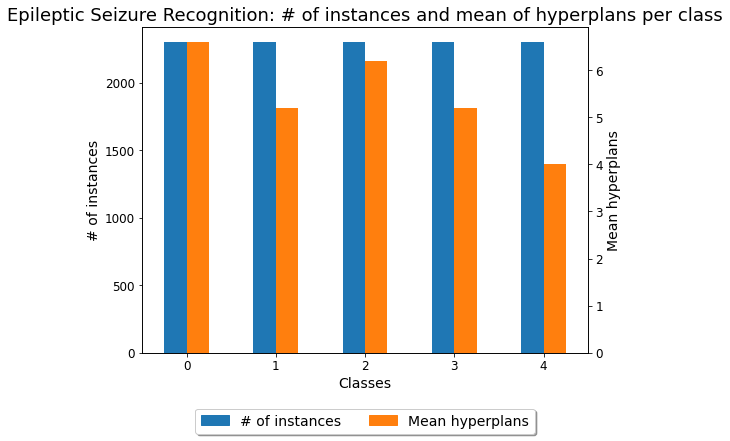

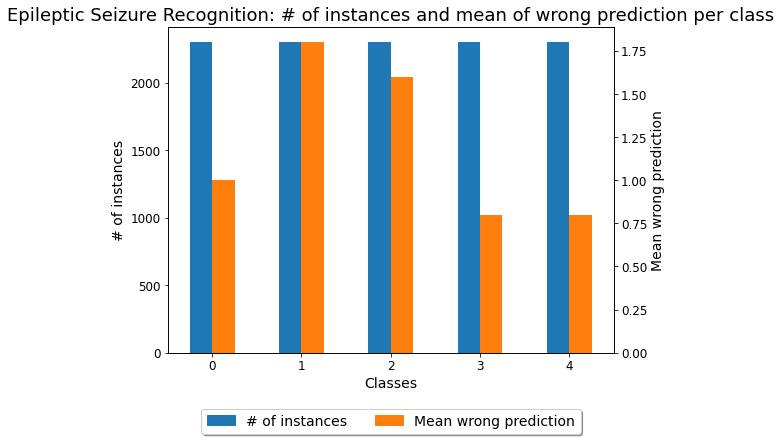

In [29]:
get_number_of_instances_hyperplans(epileptic_data, epileptic_sgh_results_json, "Epileptic Seizure Recognition: # of instances and mean of hyperplans per class"), 
get_number_of_wrong_prediction(epileptic_data, epileptic_sgh_results_json, "Epileptic Seizure Recognition: # of instances and mean of wrong prediction per class")